In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset

# Check GPU status
print("Torch CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

Torch CUDA available: True
Device: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

# Try reading as XLSX first
try:
    df = pd.read_excel("/content/Mental Sentiment Report.xlsx", engine="openpyxl")
except:
    # If that fails, try reading as XLS (older format)
    df = pd.read_excel("/content/Mental Sentiment Report.xlsx", engine="xlrd")

df.dropna(inplace=True)
df.head(2)

,Statement,Status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety


In [4]:
# Data Preprocessing
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already present
nltk.download("stopwords", quiet=True)
stop_words = set(stopwords.words("english"))

def clean_statement(text):
    # Ensure text is string and lowercase
    text = str(text).lower().strip()

    # Remove everything except letters and spaces
    text = re.sub(r"[^a-z\s]", " ", text)

    # Tokenization + remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]

    return " ".join(words)

# Apply cleaning to the 'Statement' column
df["Statement"] = df["Statement"].apply(clean_statement)

# Quick check
print(df["Statement"].head())


0                                              oh gosh
1    trouble sleeping confused mind restless heart ...
2    wrong back dear forward doubt stay restless re...
3           shifted focus something else still worried
4                     restless restless month boy mean
Name: Statement, dtype: object


/tmp/ipython-input-672034701.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, order=y.value_counts().index, palette="viridis")


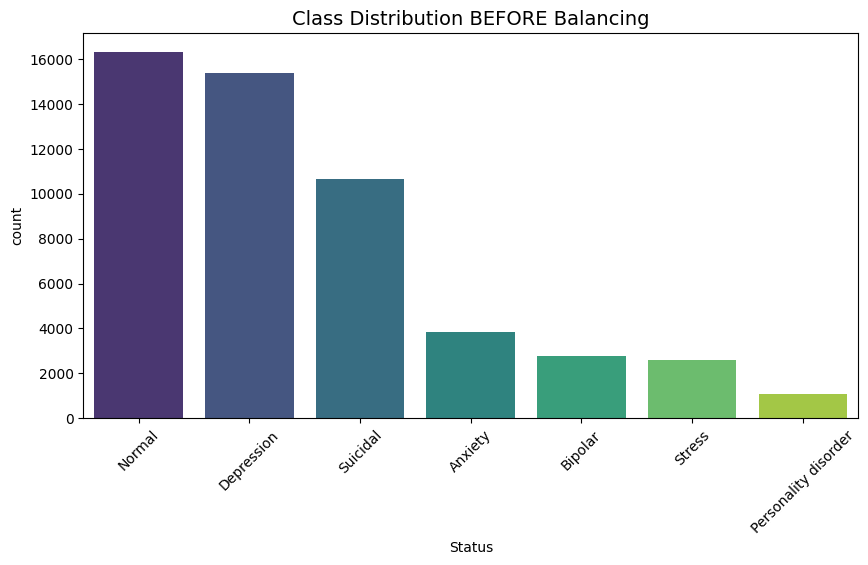

/tmp/ipython-input-672034701.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_over["Status"], order=df_over["Status"].value_counts().index, palette="magma")


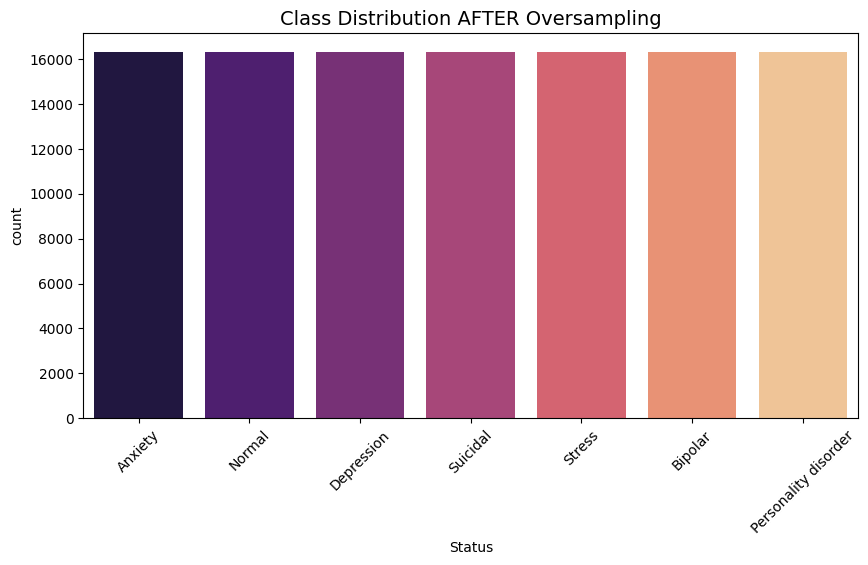

Oversampling counts:
Status
Anxiety                 16340
Normal                  16340
Depression              16340
Suicidal                16340
Stress                  16340
Bipolar                 16340
Personality disorder    16340
Name: count, dtype: int64 



/tmp/ipython-input-672034701.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_under["Status"], order=df_under["Status"].value_counts().index, palette="coolwarm")


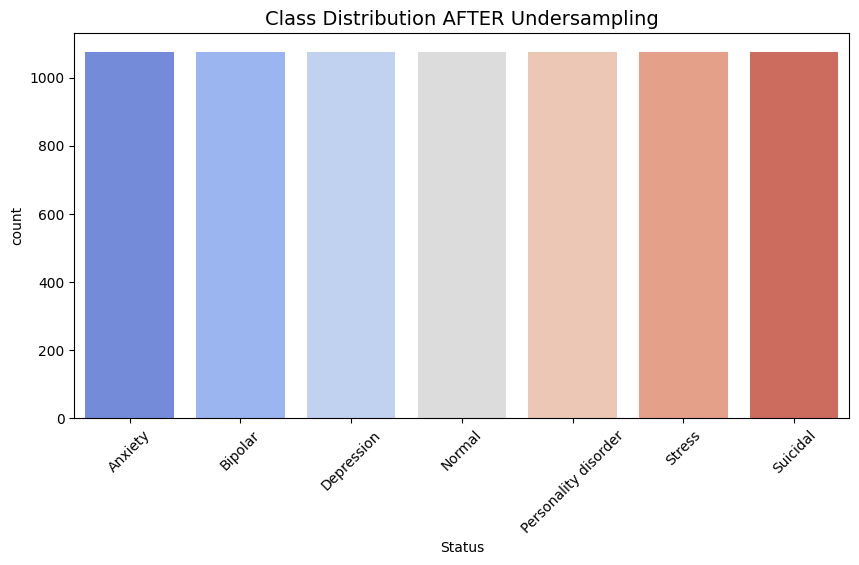

Undersampling counts:
Status
Anxiety                 1077
Bipolar                 1077
Depression              1077
Normal                  1077
Personality disorder    1077
Stress                  1077
Suicidal                1077
Name: count, dtype: int64


In [5]:
# Data Balancing (Oversampling & Undersampling)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Features and target
X = df.drop("Status", axis=1)
y = df["Status"]

# Plot original class distribution
plt.figure(figsize=(10,5))
sns.countplot(x=y, order=y.value_counts().index, palette="viridis")
plt.title("Class Distribution BEFORE Balancing", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 1️⃣ Oversampling
ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
X_over, y_over = ros.fit_resample(X, y)
df_over = pd.concat([X_over, y_over], axis=1)

plt.figure(figsize=(10,5))
sns.countplot(x=df_over["Status"], order=df_over["Status"].value_counts().index, palette="magma")
plt.title("Class Distribution AFTER Oversampling", fontsize=14)
plt.xticks(rotation=45)
plt.show()

print("Oversampling counts:")
print(df_over["Status"].value_counts(), "\n")

# 2️⃣ Undersampling
rus = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_under, y_under = rus.fit_resample(X, y)
df_under = pd.concat([X_under, y_under], axis=1)

plt.figure(figsize=(10,5))
sns.countplot(x=df_under["Status"], order=df_under["Status"].value_counts().index, palette="coolwarm")
plt.title("Class Distribution AFTER Undersampling", fontsize=14)
plt.xticks(rotation=45)
plt.show()

print("Undersampling counts:")
print(df_under["Status"].value_counts())

In [6]:
# 🔹 Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Encode the 'Status' column into numeric labels
df['label'] = label_encoder.fit_transform(df['Status'])

# Show mapping from class → label
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Check the first few rows
df.head(3)

Label Mapping: {'Anxiety': np.int64(0), 'Bipolar': np.int64(1), 'Depression': np.int64(2), 'Normal': np.int64(3), 'Personality disorder': np.int64(4), 'Stress': np.int64(5), 'Suicidal': np.int64(6)}


,Statement,Status,label
0,oh gosh,Anxiety,0
1,trouble sleeping confused mind restless heart ...,Anxiety,0
2,wrong back dear forward doubt stay restless re...,Anxiety,0


In [7]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast

# 1️⃣ Train-Test Split (using encoded labels)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Statement'],  # features
    df['label'],      # encoded labels (not Status!)
    test_size=0.2,
    random_state=42,
    stratify=df['label']  # ensures stratification after balancing
)

# 2️⃣ Load Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# 3️⃣ Tokenize Data
train_encodings = tokenizer(
    train_texts.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

test_encodings = tokenizer(
    test_texts.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [8]:
import torch
from datasets import Dataset

# Build Hugging Face Dataset objects using encodings + labels
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': torch.tensor(train_labels.values, dtype=torch.long)
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': torch.tensor(test_labels.values, dtype=torch.long)
})

# Check the first example
print("Sample from training dataset:")
print(train_dataset[0])

# Check dataset sizes
print("\nDataset sizes:")
print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

# Check label distribution
print("\nLabel distribution in Train set:")
print(pd.Series(train_labels).value_counts())

print("\nLabel distribution in Test set:")
print(pd.Series(test_labels).value_counts())

Sample from training dataset:
{'input_ids': [101, 4895, 7583, 17872, 2183, 2095, 3728, 2496, 3974, 8239, 2568, 10086, 4283, 6040, 2113, 3129, 3305, 3791, 16957, 7355, 2210, 10457, 7062, 3473, 29398, 8040, 4048, 6844, 10354, 25969, 3512, 2388, 2428, 2491, 9211, 2412, 3092, 4288, 2034, 19960, 17872, 11441, 2467, 2371, 2388, 2471, 3724, 11616, 19960, 17872, 2351, 2086, 2214, 12930, 16668, 11704, 3276, 2158, 9828, 2673, 3140, 2175, 2131, 19960, 17872, 2224, 3806, 7138, 3241, 4689, 2179, 2204, 19960, 25025, 2777, 3129, 2145, 14868, 10909, 3025, 3276, 3129, 5881, 2360, 3724, 2812, 2081, 2356, 2191, 7928, 15690, 2228, 4452, 19960, 2015, 2183, 4053, 3971, 8909, 2243, 2144, 19960, 2015, 2218, 2307, 3105, 2196, 3277, 2551, 4312, 2015, 2228, 2066, 2388, 6698, 2228, 2302, 19960, 2015, 9906, 2514, 2066, 2147, 6114, 4647, 3579, 3276, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [9]:
# Load pre-trained BERT model for sequence classification
num_labels = len(df['label'].unique())

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    save_total_limit=2
)

print("✅ Model & TrainingArguments created successfully")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model & TrainingArguments created successfully


In [10]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from transformers import Trainer

# Function to compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("Trainer initialized ✅")

Trainer initialized ✅


In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aananalyst (aananalyst-aandevanalyst) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,1.690300
200,1.256800
300,1.121900
400,0.949600
500,0.862700
600,0.831700
700,0.751500
800,0.777500
900,0.705600
1000,0.673300


In [12]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.6254795789718628, 'eval_accuracy': 0.7989176872685845, 'eval_f1': 0.798792040701601, 'eval_runtime': 75.4884, 'eval_samples_per_second': 139.531, 'eval_steps_per_second': 8.73, 'epoch': 3.0}


In [13]:
# Save the trained model and tokenizer
import joblib

# Save model and tokenizer
save_dir = "./saved_model"
trainer.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

# Save label encoder
joblib.dump(label_encoder, f"{save_dir}/label_encoder.pkl")

print(f"✅ Model, tokenizer, and label encoder saved in {save_dir}")

✅ Model, tokenizer, and label encoder saved in ./saved_model


In [14]:
# Get predictions on test set
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# Detailed classification report
print("Classification Report:")
print(classification_report(labels, preds, target_names=label_encoder.classes_))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(labels, preds))


Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.84      0.85      0.85       768
             Bipolar       0.84      0.82      0.83       556
          Depression       0.74      0.73      0.73      3079
              Normal       0.93      0.94      0.94      3268
Personality disorder       0.73      0.68      0.71       215
              Stress       0.66      0.65      0.66       517
            Suicidal       0.69      0.71      0.70      2130

            accuracy                           0.80     10533
           macro avg       0.78      0.77      0.77     10533
        weighted avg       0.80      0.80      0.80     10533

Confusion Matrix:
[[ 652   23   42   10   15   23    3]
 [  17  457   49   11    4   10    8]
 [  45   38 2234   82   17   46  617]
 [  17    5   55 3074    5   71   41]
 [   3    4   44    7  147    6    4]
 [  38    4   65   45    9  337   19]
 [   2   14  519   62    4   15 1514]]


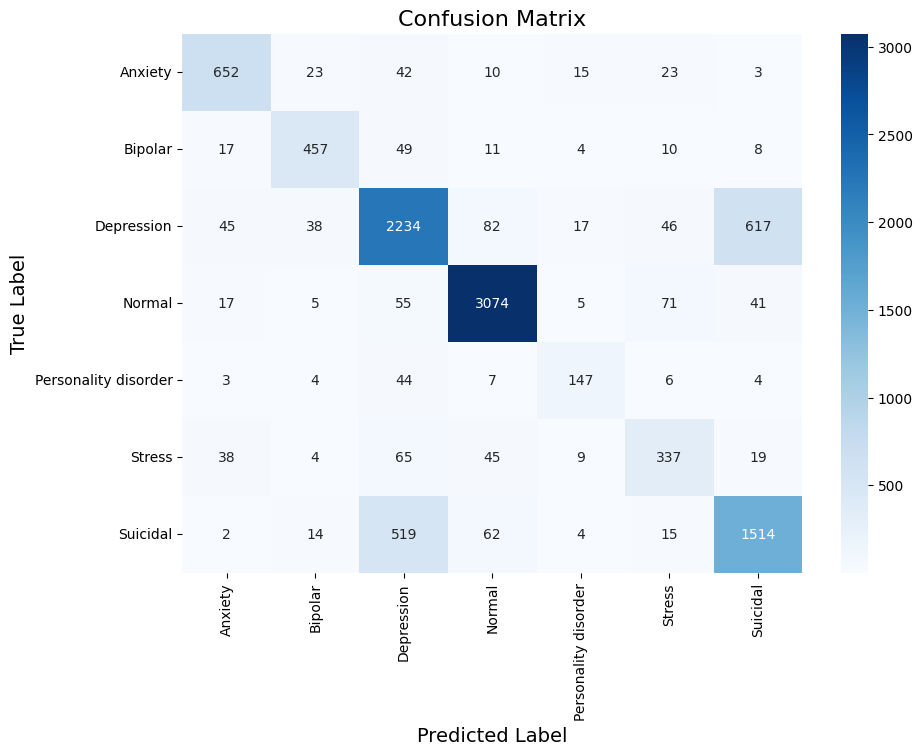

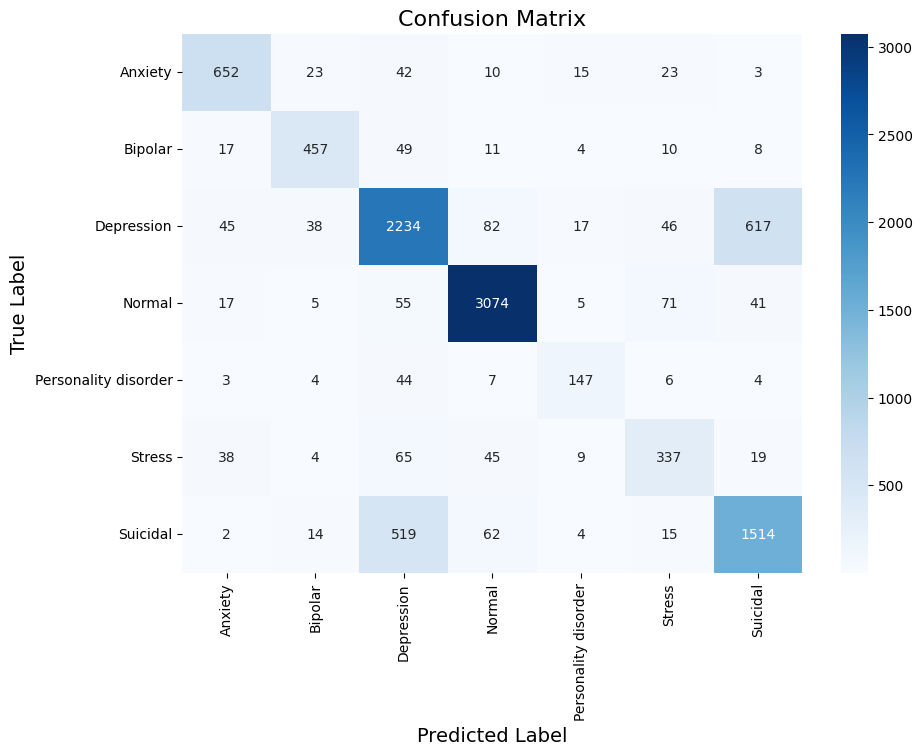

In [16]:
# ✅ Get predictions from Trainer
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

# ✅ Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# ✅ Define labels using your encoder
labels = label_encoder.classes_

# ✅ Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels,
            yticklabels=labels)

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()


In [18]:
from transformers import BertTokenizer, BertForSequenceClassification
import joblib
import torch

# Path to your saved directory
save_dir = "./saved_model"

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained(save_dir)
tokenizer = BertTokenizer.from_pretrained(save_dir)

# Load label encoder
label_encoder = joblib.load(f"{save_dir}/label_encoder.pkl")

# Put model in evaluation mode
model.eval()

# 🔮 Function for prediction
def predict(texts):
    # Tokenize input texts
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).numpy()

    # Convert back to original labels
    labels = label_encoder.inverse_transform(preds)
    return labels

# ✅ Example usage
sample_texts = [
    "I feel so lonely and depressed these days.",
    "Life is going well and I’m really happy!"
]

predictions = predict(sample_texts)
print("Predictions:", predictions)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Predictions: ['Depression' 'Normal']
